# Inception Net

## Imports

In [1]:
import tensorflow as tf

## Inception Module

In [2]:
def add_inception_module(input_layer, conv_1_1, reduce_3_3, conv_3_3, reduce_5_5, conv_5_5, pool):
    # 1x1 conv
    layer_conv_1_1 = tf.keras.layers.Conv2D(conv_1_1, (3,3), activation='relu', padding='same')(input_layer)
    
    # 3x3 conv
    layer_conv_3_3 = tf.keras.layers.Conv2D(reduce_3_3, (1,1), activation='relu', padding='same')(input_layer)
    layer_conv_3_3 = tf.keras.layers.Conv2D(conv_3_3, (3,3), activation='relu', padding='same')(layer_conv_3_3)
    
    # 5x5 conv
    layer_conv_5_5 = tf.keras.layers.Conv2D(reduce_5_5, (1,1), activation='relu', padding='same')(input_layer)
    layer_conv_5_5 = tf.keras.layers.Conv2D(conv_5_5, (5,5), activation='relu', padding='same')(layer_conv_5_5)
    
    # 1x1 conv with max pool
    layer_conv_1_1_pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    layer_conv_1_1_pool = tf.keras.layers.Conv2D(pool, (1,1), activation='relu', padding='same')(layer_conv_1_1_pool)
    
    return tf.keras.layers.Concatenate()([layer_conv_1_1, layer_conv_3_3, layer_conv_5_5, layer_conv_1_1_pool])

## Auxiliary Classifier

In [3]:
def add_auxiliary_classifier(input_layer):
    x = tf.keras.layers.AveragePooling2D((5,5), strides=(3,3))(input_layer)
    x = tf.keras.layers.Conv2D(128, (1,1), activation='relu')(input_layer)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(1000, activation='softmax')(x)
    return x

## Google Net

In [4]:
def get_google_net():
    input = tf.keras.Input((224, 224, 3))
    x = tf.keras.layers.Conv2D(64, (7,7), strides=(2,2), activation='relu', padding='same')(input)
    assert x.shape[1:] == (112, 112, 64)
    x = tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same')(x)
    assert x.shape[1:] == (56, 56, 192)
    x = tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same')(x)
    assert x.shape[1:] == (28, 28, 192)
    
    # inception 3a
    x = add_inception_module(x, conv_1_1=64, reduce_3_3=96, conv_3_3=128, reduce_5_5=16, conv_5_5=32, pool=32)
    # inception 3b
    x = add_inception_module(x, conv_1_1=128, reduce_3_3=128, conv_3_3=192, reduce_5_5=32, conv_5_5=96, pool=64)
    assert x.shape[1:] == (28, 28, 480), print(x.shape)
    
    x = tf.keras.layers.MaxPool2D((3,3), strides=2, padding='same')(x)
    # inception 4a
    x = add_inception_module(x, conv_1_1=192, reduce_3_3=96, conv_3_3=208, reduce_5_5=16, conv_5_5=48, pool=64)
    # inception 4b
    x1 = add_inception_module(x, conv_1_1=160, reduce_3_3=112, conv_3_3=224, reduce_5_5=24, conv_5_5=64, pool=64)
    softmax_0 = add_auxiliary_classifier(x)
    assert x1.shape[1:] == (14, 14, 512), print(x1.shape)
    
    # inception 4c
    x = add_inception_module(x1, conv_1_1=128, reduce_3_3=128, conv_3_3=256, reduce_5_5=24, conv_5_5=64, pool=64)
    # inception 4d
    x = add_inception_module(x, conv_1_1=112, reduce_3_3=144, conv_3_3=288, reduce_5_5=32, conv_5_5=64, pool=64)
    # inception 4e
    x1 = add_inception_module(x, conv_1_1=256, reduce_3_3=160, conv_3_3=320, reduce_5_5=32, conv_5_5=128, pool=128)
    softmax_1 = add_auxiliary_classifier(x)
    assert x1.shape[1:] == (14, 14, 832), print(x1.shape)
    
    x = tf.keras.layers.MaxPool2D((3,3), strides=2, padding='same')(x1)
    # inception 5a
    x = add_inception_module(x, conv_1_1=256, reduce_3_3=160, conv_3_3=320, reduce_5_5=32, conv_5_5=128, pool=128)
    # inception 5b
    x = add_inception_module(x, conv_1_1=384, reduce_3_3=192, conv_3_3=384, reduce_5_5=48, conv_5_5=128, pool=128)
    assert x.shape[1:] == (7, 7, 1024), print(x.shape)
    
    x = tf.keras.layers.AveragePooling2D((7,7))(x)
    assert x.shape[1:] == (1, 1, 1024), print(x.shape)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    softmax_2 = tf.keras.layers.Dense(1000, activation='softmax')(x)
    
    model = tf.keras.Model(input, [softmax_2, softmax_1, softmax_0], name='GoogleNet')
    
    return model

## Model Initialization and Summary

In [5]:
google_net = get_google_net()
google_net.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

## Model Flow Diagram

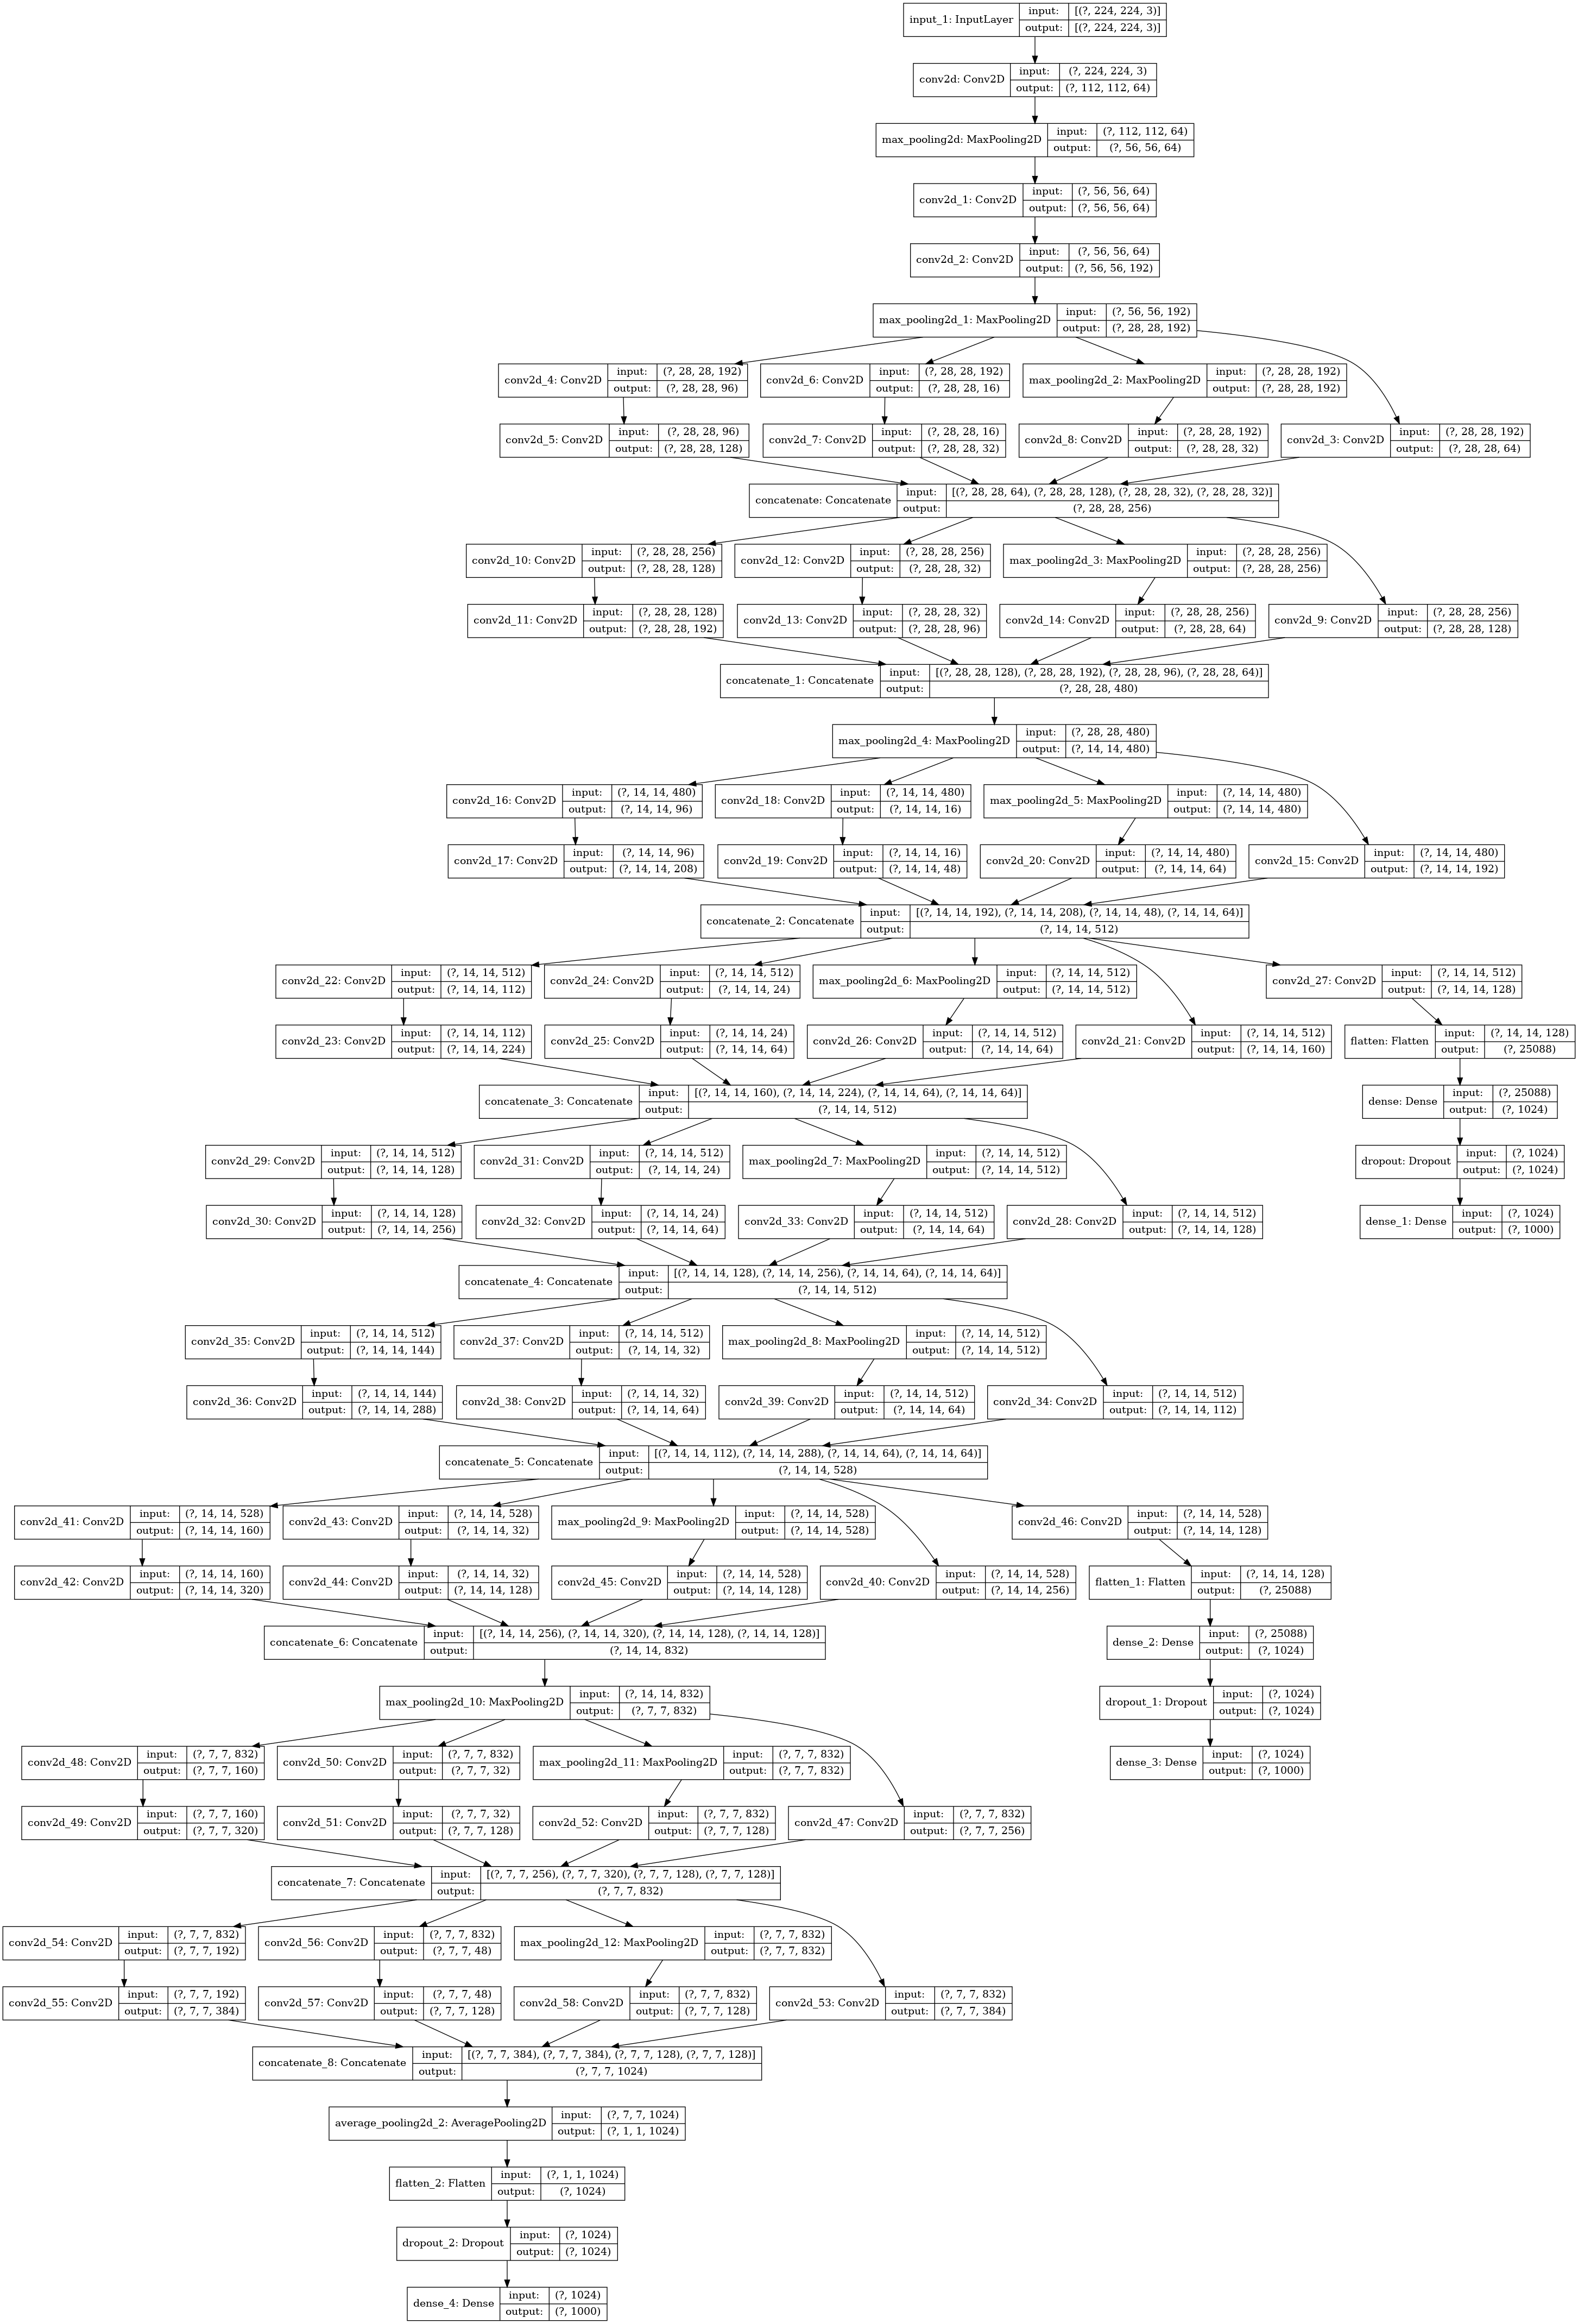

In [8]:
tf.keras.utils.plot_model(google_net, to_file='google_net_22.png', show_shapes=True)

In [9]:
google_net.save('google_net_22')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: google_net_22/assets


In [10]:
sgs_optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)

In [12]:
google_net.compile?

Signature:
google_net.compile(
    optimizer='rmsprop',
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    **kwargs,
)
Docstring:
Configures the model for training.

Arguments:
    optimizer: String (name of optimizer) or optimizer instance. See
      `tf.keras.optimizers`.
    loss: String (name of objective function), objective function or
      `tf.keras.losses.Loss` instance. See `tf.keras.losses`. An objective
      function is any callable with the signature `loss = fn(y_true,
      y_pred)`, where y_true = ground truth values with shape =
      `[batch_size, d0, .. dN]`, except sparse loss functions such as sparse
      categorical crossentropy where shape = `[batch_size, d0, .. dN-1]`.
      y_pred = predicted values with shape = `[batch_size, d0, .. dN]`. It
      returns a weighted loss float tensor. If a custom `Loss` instance is
      used and reduction is set to NONE, return value has the shape
      [batch_size, d0

In [14]:
google_net.compile(
    optimzer='sgd',
    loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy'])

TypeError: Invalid keyword argument(s) in `compile`: {'optimzer'}